In [13]:
# Initialization
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.utils import np_utils # one-hot-encoding

# Required for loss function
import math
from tensorflow.python.keras import losses

import tensorflow as tf

In [9]:
# Set someparameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
IMG_CHANNELS = 3

MODEL_NAME = 'model-lab-unet-1.h5'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [10]:
# Import the data
# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
TRAIN_PATH = 'F:\\MA\\data\\dataset_lab\\train\\'
TEST_PATH = 'F:\MA\\data\\dataset_lab\\test\\'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
test_ids = next(os.walk(TEST_PATH + 'in/'))[2]

# Get and resize train images and masks
# X_train: original images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# Y_train: masks
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# X_train: original images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# Y_train: masks
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')

sys.stdout.flush()


for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH + 'in/' + id_)
    img = img[:,:,np.newaxis]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    X_train[n] = img
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    mask = imread(TRAIN_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    #mask = mask[:,:,np.newaxis]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np_utils.to_categorical(mask, IMG_CHANNELS) # Generate binary masks (one hot encoding)
    Y_train[n] = mask
    
    
# Get and resize test images
#X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#    path = TEST_PATH + id_
    img = imread(TEST_PATH + 'in/' + id_)
    img = img[:,:,np.newaxis]
#    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = imread(TEST_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    mask = mask[:,:,np.newaxis]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np_utils.to_categorical(mask, IMG_CHANNELS) # Generate binary masks (one hot encoding)
    Y_test[n] = mask
    

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:10<00:00, 45.22it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 44.25it/s]


Done!


In [11]:
# Define custom metrics and loss functions
def dice_coeff(y_true,y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true , y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss (y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
    return loss

# The same as log_loss
def mlogloss(target, pred):
    score = 0.0
    for i in range(len(pred)):
        pp = pred[i]
        for j in range(len(pp)):
            prob = pp[j]
            if prob < 1e-15:
                prob = 1e-15
            score += target[i][j] * math.log(prob)
    return -score/len(pred)

In [29]:
dice_coeff(1, 1)

TypeError: Expected int32, got 2.0 of type 'float' instead.

In [28]:
# Test
ix = random.randint(0, len(train_ids))
mask_category = 0

print(type(Y_train[ix,1,1,mask_category]))
print(type(preds_train_t[ix,1,1,mask_category]))
#print(dice_coeff(Y_train[ix,:,:,mask_category], preds_train_t[ix,:,:,mask_category]))
print(dice_coeff(Y_train[ix], preds_train_t[ix]))

<class 'numpy.uint8'>
<class 'numpy.uint8'>


TypeError: Expected uint8, got 2.0 of type 'float' instead.

In [14]:
# Predict on train, val and test
model = load_model(MODEL_NAME, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_loss': dice_loss})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
#for i in range(len(preds_test)):
#    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                       (sizes_test[i][0], sizes_test[i][1]), 
#                                       mode='constant', preserve_range=True))

Instructions for updating:
Use tf.cast instead.
34/34 [==============================] - ETA:  - 1s 42ms/step


In [15]:
print(preds_test.shape)

(34, 128, 128, 3)


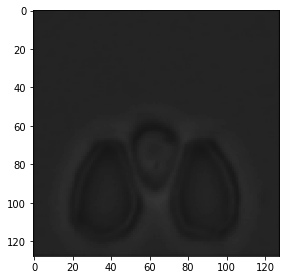

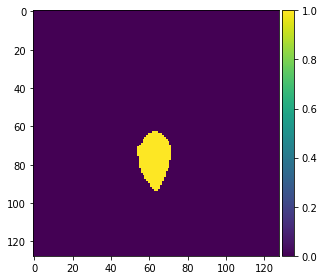

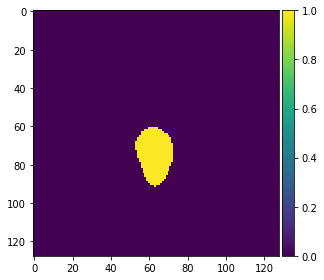

In [33]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(train_ids))
mask_category = 2 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_train[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(np.squeeze(Y_train[ix,:,:,mask_category])) 
plt.show()
imshow(np.squeeze(preds_train_t[ix,:,:,mask_category]))
plt.show()

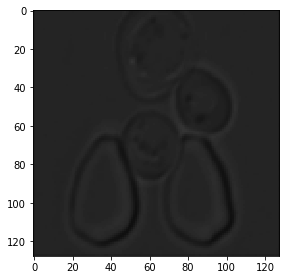

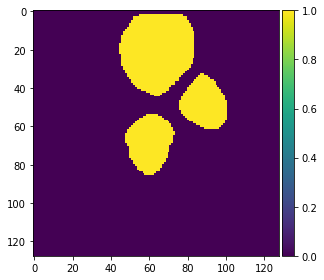

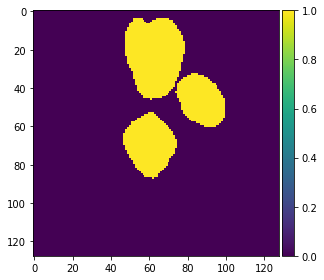

In [19]:
ix = random.randint(0, len(test_ids))
mask_category = 0 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(np.squeeze(Y_test[ix,:,:,mask_category])) 
plt.show()
imshow(np.squeeze(preds_test_t[ix,:,:,mask_category]))
plt.show()